In [7]:
import pandas as pd
from os.path import join, basename
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
from dask import dataframe as dd

from deep_aqi import ROOT


pd.set_option('max_columns', 50)

### globals

In [2]:
RAW_DATA = join(ROOT, 'data', 'raw')
INTERIM_DATA = join(ROOT, 'data', 'interim')

In [3]:
files = glob(f'{RAW_DATA}/*.csv', recursive=True)
files

['/home/filip/projects/deep_aqi/deep_aqi/data/raw/hourly_WIND_2017.csv',
 '/home/filip/projects/deep_aqi/deep_aqi/data/raw/hourly_PRESS_2017.csv',
 '/home/filip/projects/deep_aqi/deep_aqi/data/raw/hourly_88101_2017.csv',
 '/home/filip/projects/deep_aqi/deep_aqi/data/raw/hourly_TEMP_2017.csv']

In [4]:
file = files[0]
basename(file).split('.')[0]

'hourly_WIND_2017'

In [23]:
data = dd.read_csv(files[0], dtype={'Qualifier': 'object'})

In [25]:
data.isnull().sum().compute()

State Code                    0
County Code                   0
Site Num                      0
Parameter Code                0
POC                           0
Latitude                      0
Longitude                     0
Datum                         0
Parameter Name                0
Date Local                    0
Time Local                    0
Date GMT                      0
Time GMT                      0
Sample Measurement            0
Units of Measure              0
MDL                           0
Uncertainty            12399465
Qualifier              12366883
Method Type                   0
Method Code                   0
Method Name                   0
State Name                    0
County Name                   0
Date of Last Change           0
dtype: int64

In [13]:
data.isnull().sum().compute()

/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/dask/local.py:272: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+-----------+--------+----------+
| Column    | Found  | Expected |
+-----------+--------+----------+
| Qualifier | object | float64  |
+-----------+--------+----------+

The following columns also raised exceptions on conversion:

- Qualifier
  ValueError("could not convert string to float: 'SX'",)

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'Qualifier': 'object'}

to the call to `read_csv`/`read_table`.

In [5]:
def californication(file_path):
    """Narrows down to California"""
    print('Loading file from csv...')
    data = pd.read_csv(file_path)
    data = data.loc[data['State Name'] == 'California', :]
    file_name = basename(file_path).split('.')[0]
    save_path = join(INTERIM_DATA, file_name)
    print('Saving file to parquet...')
    data.to_parquet(save_path, engine='fastparquet', compression='SNAPPY')

In [6]:
californication(files[0])

Loading file from csv...


/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saving file to parquet...


ValueError: Error converting column "Qualifier" to bytes using encoding None. Original error: could not convert string to float: 'ND'

## TEMP

In [17]:
df = pd.read_csv(files[3])

/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
states = [state[0] for state in Counter(df['State Name']).most_common(10)]
Counter(df['State Name']).most_common(10)

[('California', 1369634),
 ('Texas', 920946),
 ('Wyoming', 808455),
 ('Michigan', 363966),
 ('Colorado', 288045),
 ('Missouri', 239066),
 ('Oklahoma', 210361),
 ('Utah', 206153),
 ('New Mexico', 186542),
 ('Washington', 166432)]

In [61]:
sns.set(rc={'figure.figsize':(11, 6)})

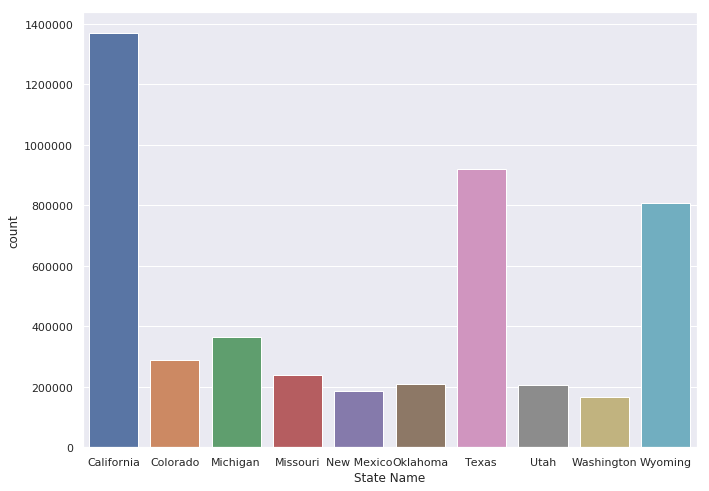

In [60]:
sns.countplot(df.loc[df['State Name'].isin(states),'State Name'])

## WIND

In [7]:
df = pd.read_csv(files[0])

/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
states = [state[0] for state in Counter(df['State Name']).most_common(10)]
Counter(df['State Name']).most_common(10)

[('California', 2598396),
 ('Texas', 1838044),
 ('Michigan', 738781),
 ('Arizona', 671723),
 ('Colorado', 446625),
 ('Missouri', 387865),
 ('Indiana', 367130),
 ('Iowa', 330366),
 ('Wisconsin', 316214),
 ('Oklahoma', 313546)]

In [9]:
sns.set(rc={'figure.figsize':(11, 6)})

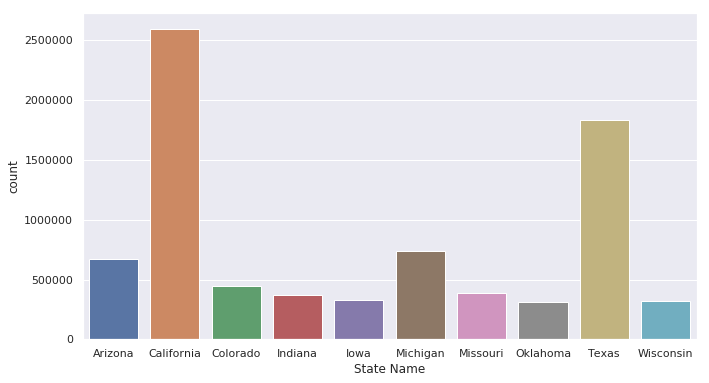

In [10]:
sns.countplot(df.loc[df['State Name'].isin(states),'State Name'])

## PRESS

In [4]:
df = pd.read_csv(files[1])

/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
states = [state[0] for state in Counter(df['State Name']).most_common(10)]
Counter(df['State Name']).most_common(10)

[('California', 417400),
 ('Wyoming', 363049),
 ('Michigan', 187026),
 ('Maryland', 131257),
 ('New York', 131196),
 ('Missouri', 129985),
 ('Idaho', 128357),
 ('Massachusetts', 113637),
 ('Iowa', 101256),
 ('Oregon', 89482)]

In [6]:
sns.set(rc={'figure.figsize':(11, 6)})

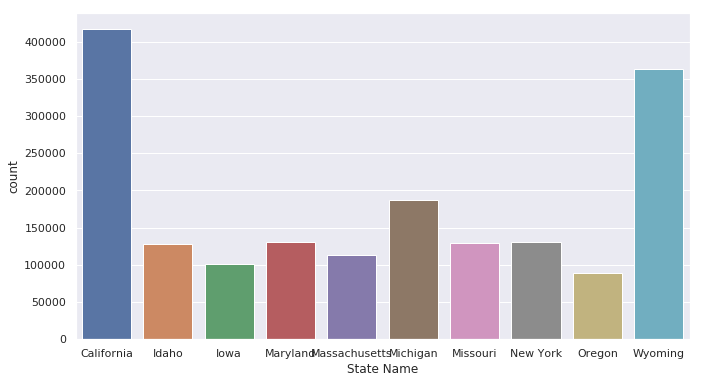

In [7]:
sns.countplot(df.loc[df['State Name'].isin(states),'State Name'])

## PM2.5

In [7]:
df = pd.read_csv(files[2])

/home/filip/miniconda3/envs/deep_aqi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
states = [state[0] for state in Counter(df['State Name']).most_common(10)]
Counter(df['State Name']).most_common(10)

[('California', 603190),
 ('Pennsylvania', 315199),
 ('Minnesota', 184360),
 ('Indiana', 157440),
 ('Wisconsin', 153224),
 ('Washington', 152283),
 ('Arizona', 136504),
 ('Montana', 136258),
 ('Utah', 118323),
 ('Missouri', 116704)]

In [9]:
sns.set(rc={'figure.figsize':(11, 6)})

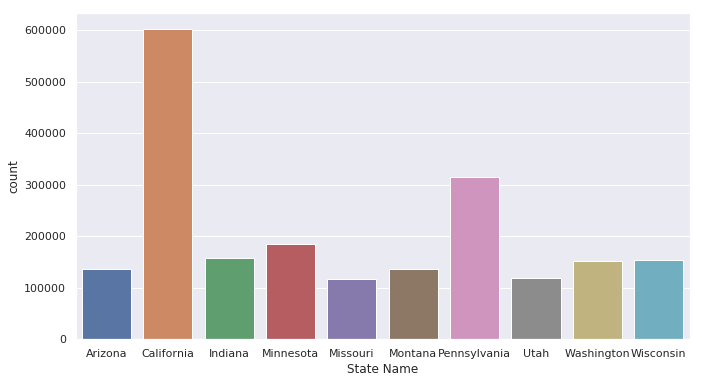

In [10]:
sns.countplot(df.loc[df['State Name'].isin(states),'State Name'])